In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
from tqdm import tqdm
import gensim
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
stop_words = stopwords.words('english')
import pyemd
pal = sns.color_palette()


import csv, json
from zipfile import ZipFile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

/anaconda/envs/py35/lib/python3.5/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
Using TensorFlow backend.


In [2]:
print("Extracting features for train:")
train_df = pd.read_csv("train.csv")

Extracting features for train:


In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print('Total number of question pairs in data: {}'.format(len(train_df)))
print('Duplicate pairs: {}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))

Total number of question pairs in data: 404290
Duplicate pairs: 36.92%


In [5]:
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
print('Total number of questions in the data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear more than once: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of questions in the data: 537933
Number of questions that appear more than once: 111780


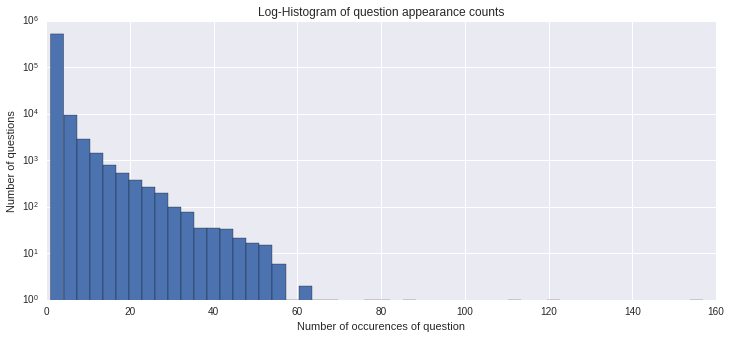

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

Mean of # of characters in Questions 1 59.54
Std Dev of # of characters in Questions 1 29.94
Minimum of # of characters in Questions 1 1.00
Maximum of # of characters in Questions 1 623.00
Mean of # of characters in Questions 2 60.11
Std Dev of # of characters in Questions 2 33.86
Minimum of # of characters in Questions 2 1.00
Maximum of # of characters in Questions 2 1169.00


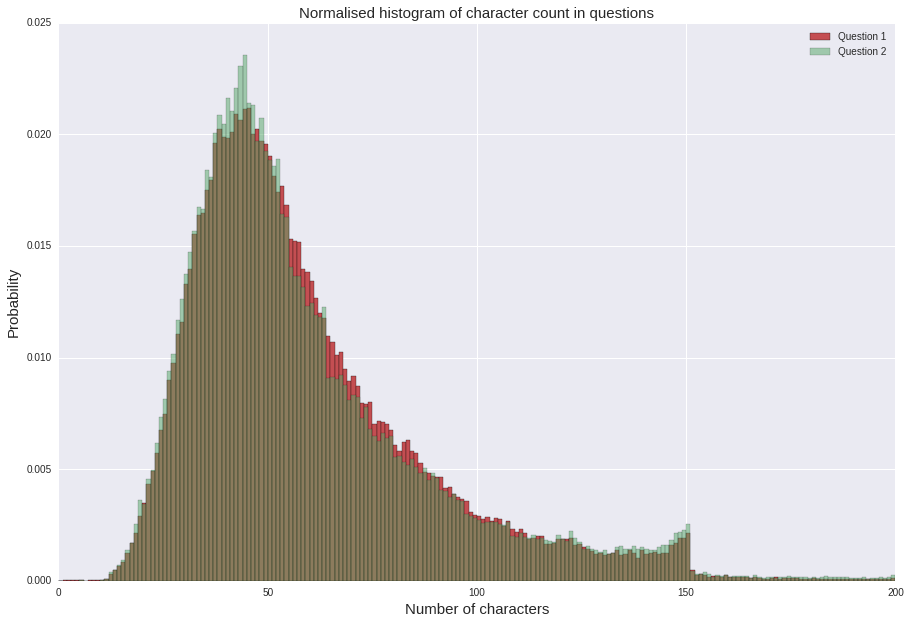

In [7]:
#distribution of characters
qs1 = pd.Series(train_df['question1'].tolist()).astype(str)
qs2 = pd.Series(train_df['question2'].tolist()).astype(str)
qs = qs1 + qs2
dist_qs1 = qs1.apply(len)
dist_qs2 = qs2.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_qs1, bins=200, range=[0, 200], color=pal[2], normed=True, label='Question 1')
plt.hist(dist_qs2, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='Question 2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Mean of # of characters in Questions 1 {:.2f}'.format(dist_qs1.mean()))
print('Std Dev of # of characters in Questions 1 {:.2f}'.format(dist_qs1.std()))
print('Minimum of # of characters in Questions 1 {:.2f}'.format(dist_qs1.min()))
print('Maximum of # of characters in Questions 1 {:.2f}'.format(dist_qs1.max()))
print('Mean of # of characters in Questions 2 {:.2f}'.format(dist_qs2.mean()))
print('Std Dev of # of characters in Questions 2 {:.2f}'.format(dist_qs2.std()))
print('Minimum of # of characters in Questions 2 {:.2f}'.format(dist_qs2.min()))
print('Maximum of # of characters in Questions 2 {:.2f}'.format(dist_qs2.max()))

Mean of # of words in Questions 1 10.94
Std Dev of # of words in Questions 1 5.43
Minimum of # of words in Questions 1 1.00
Maximum of # of words in Questions 1 125.00
Mean of # of words in Questions 2 11.19
Std Dev of # of words in Questions 2 6.31
Minimum of # of words in Questions 2 1.00
Maximum of # of words in Questions 2 237.00


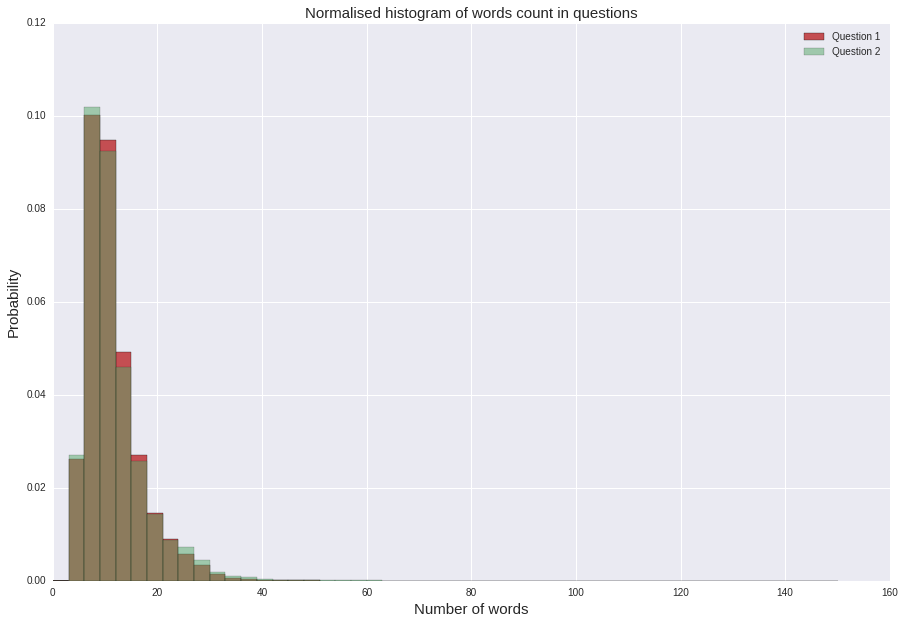

In [8]:
#distribution of words
dist_qs1 = qs1.apply(lambda x: len(x.split(' ')))
dist_qs2 = qs2.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_qs1, bins=50, range=[0, 150], color=pal[2], normed=True, label='Question 1')
plt.hist(dist_qs2, bins=50, range=[0, 150], color=pal[1], normed=True, alpha=0.5, label='Question 2')
plt.title('Normalised histogram of words count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Mean of # of words in Questions 1 {:.2f}'.format(dist_qs1.mean()))
print('Std Dev of # of words in Questions 1 {:.2f}'.format(dist_qs1.std()))
print('Minimum of # of words in Questions 1 {:.2f}'.format(dist_qs1.min()))
print('Maximum of # of words in Questions 1 {:.2f}'.format(dist_qs1.max()))
print('Mean of # of words in Questions 2 {:.2f}'.format(dist_qs2.mean()))
print('Std Dev of # of words in Questions 2 {:.2f}'.format(dist_qs2.std()))
print('Minimum of # of words in Questions 2 {:.2f}'.format(dist_qs2.min()))
print('Maximum of # of words in Questions 2 {:.2f}'.format(dist_qs2.max()))

In [9]:
stops = set(stopwords.words("english"))
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


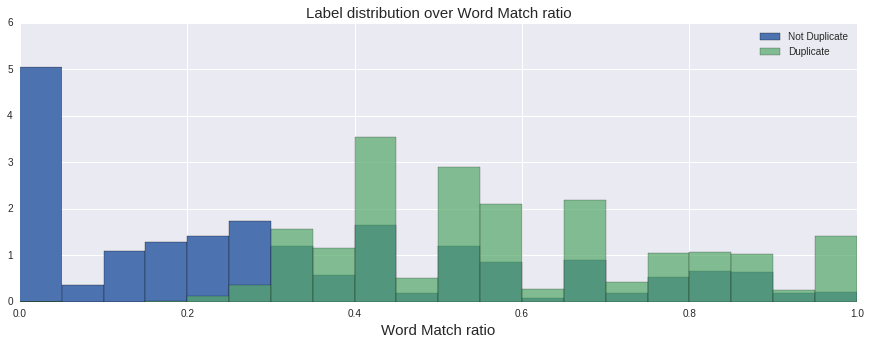

In [10]:
plt.figure(figsize=(15, 5))
word_match = train_df.apply(word_match_share, axis=1, raw=True)
plt.hist(word_match[train_df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(word_match[train_df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over Word Match ratio', fontsize=15)
plt.xlabel('Word Match ratio', fontsize=15)

# cleanup text data

In [11]:
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'

In [12]:
from os.path import expanduser, exists
if not exists(GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE,GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE)

In [13]:
import re

abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",
    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",
    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",
    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    '\s+':' ', 
}


def text_to_tokens(text):
    
    if type(text) is str:
        
    #print(text)
        text = text.lower().split()

        #replace common abbreviations 
        text = [ abbr_dict[w] if w in abbr_dict else w for w in text ]
        text = " ".join(text)
        #lets remove all punctuations
        text = re.sub('[0-9\(\)\!\^\%\$\'\"\.;,-\?\{\}\[\]\\/]', ' ', text)
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = [w for w in text if w.isalpha() and len(w) > 1]
        text = " ".join(text)

        return (text.strip())
    
    return ("")
    

In [14]:
train_df.dropna(how='any')
train_df['cleaned_q1'] = train_df.question1.apply(text_to_tokens)
train_df['cleaned_q2'] = train_df.question2.apply(text_to_tokens)

In [15]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cleaned_q1,cleaned_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solve,find remainder math math divided
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [16]:
train_df.to_csv('train_cleaned.csv')

In [17]:
question1 = []
question2 = []
is_duplicate = []

for index , row  in train_df[['cleaned_q1','cleaned_q2','is_duplicate']].iterrows():
    question1.append(row['cleaned_q1'])
    question2.append(row['cleaned_q2'])
    is_duplicate.append(row['is_duplicate'])
    
print('Question pairs: %d' %len(question1))

Question pairs: 404290


In [18]:
MAX_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

questions = question1 + question2
tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequence = tokenizer.texts_to_sequences(question1)
question2_word_sequence = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print('Words in index: %d' % len(word_index))

Words in index: 79168


In [19]:

embeddings_index = {}

with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
        
print('Word embeddings: %d' % len(embeddings_index))

Word embeddings: 2196016


In [20]:
#prepare word embedding matrix

nb_words = min(MAX_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
words_not_in_glove = []
for word , i in word_index.items():
    if i > MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
    else:
        words_not_in_glove.append(word)
        
print(word_embedding_matrix.shape)

(79169, 300)


In [21]:
words_not_in_glove

['réally',
 'movhash',
 'dalf',
 'proadvisor',
 'jdpo',
 'eyeem',
 'maharashtians',
 '真感情',
 'balasubramaniam',
 'zachia',
 'prgrmmng',
 'rankability',
 'tasls',
 'turbidty',
 'malbaris',
 'andmongodbb',
 'bacla',
 'scalr',
 'analsyis',
 'pucallpa',
 'possobility',
 'rangbhoomi',
 'recarnation',
 'irrfan',
 'simcash',
 'fiap',
 'qpx',
 'admovate',
 'wankhede',
 'hindutvam',
 'itlos',
 'cbit',
 'gazatted',
 'heideggers',
 'ampush',
 'wurtz',
 'utuber',
 'maheshvari',
 'titanfall',
 'cosmoem',
 'unalaska',
 'trrn',
 '吝啬',
 'valparai',
 'bronzeville',
 'draupadi',
 'awdesh',
 'konark',
 'clickbombing',
 'khesra',
 'qmas',
 'tvprogram',
 'payet',
 'tanla',
 'ghandhi',
 'praanam',
 'educhat',
 'fidlago',
 'ccpm',
 'nethralaya',
 'sitapur',
 'ervdiet',
 'polyhalite',
 'grigory',
 'bankbazaar',
 'antutu',
 'deskdop',
 'gaffar',
 'wiresshark',
 'unspreadable',
 'applits',
 'nicobars',
 'hoskote',
 'napoloeon',
 'mainak',
 'nitrobuild',
 'mesomeric',
 'zenker',
 'patanjalis',
 'ironmq',
 'ppppp

In [22]:
Q1_TRAINING_DATA_FILE = 'q1_train_{0}.npy'
Q2_TRAINING_DATA_FILE = 'q2_train_{0}.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'

maxseq = [25,40,50,75,100]

for ms in maxseq:
    q1_data = pad_sequences(question1_word_sequence, maxlen=ms)
    q2_data = pad_sequences(question2_word_sequence, maxlen=ms)
    q1file = Q1_TRAINING_DATA_FILE.format(ms)
    q2file = Q2_TRAINING_DATA_FILE.format(ms)
    np.save(open(q1file, 'wb'), q1_data)
    np.save(open(q2file, 'wb'), q2_data)
    
labels = np.array(is_duplicate, dtype=int)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)

In [23]:
from nltk import pos_tag
import nltk
import pandas as pd
import copy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
from tqdm import tqdm
import gensim
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import numpy as np
from fuzzywuzzy import fuzz

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/stp8954/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/stp8954/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
df = copy.deepcopy(train_df)

def sent2vec(s):
    words = s.split()
    
    M = []
    
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
            
    M = np.array(M)
    v = M.sum(axis=0)
    return v/np.sqrt((v**2).sum())

#pos tag features
def postag_match_share(q1, q2):
    q1words = {}
    q2words = {}
    for word in q1:
        q1words[word] = 1

    for word in q2:
        q2words[word] = 1

    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2)) / (len(q1words) + len(q2words))
    return R


def get_pos_tag_features(q1,q2):
    
    text = nltk.word_tokenize(q1)
    pq1 = list(map(lambda x: x[1], pos_tag(text)))
    
    text = nltk.word_tokenize(q2)
    pq2 = list(map(lambda x: x[1], pos_tag(text)))
    
    pos_diff = len(set(pq1).difference(set(pq2)))
    pos_symmetric_diff = len(set(pq1).symmetric_difference(set(pq2)))
    
    unique_q1 = len(set(pq1))
    unique_q2 = len(set(pq1))
    if len(pq1) == 0:
        unique_ratio_q1 = 0.0
    else:
        unique_ratio_q1 = len(set(pq1))/float(len(pq1))
        
    if len(pq2) == 0:
        unique_ratio_q2 = 0.0
    else:
        unique_ratio_q2 = len(set(pq2))/float(len(pq2))
        
    match_share = postag_match_share(pq1,pq2)
    
    
    return (pos_diff, 
            pos_symmetric_diff, 
            unique_q1, 
            unique_q2, 
            unique_ratio_q1, 
            unique_ratio_q2, match_share)

In [25]:
# question length feature
df['len_q1'] = df.cleaned_q1.apply(lambda x : len(x))
df['len_q2'] = df.cleaned_q2.apply(lambda x : len(x))
df['len_ratio'] = df.len_q1/ df.len_q2
df['diff_len_ratio'] = abs(df.len_q1 - df.len_q2) / (df.len_q1 + df.len_q2)

# Number of words in question1
df['len_word_q1'] = df.cleaned_q1.apply(lambda x: len(str(x).split()))
# Number of words in question2
df['len_word_q2'] = df.cleaned_q2.apply(lambda x: len(str(x).split()))
# ratio of number of words
df['len_word_ratio'] = df.len_word_q1 / df.len_word_q2
# ratio of difference in these lengths to total length
df['diff_len_word_ratio'] = abs(df.len_word_q1 - df.len_word_q2) / (df.len_word_q1 + df.len_word_q2)
# Number of common words in question1 and question2
df['common_words'] = df.apply(lambda x: len(set(str(x['cleaned_q1']).split()).intersection(set(str(x['cleaned_q2']).split()))), axis=1)
df['common_words_ratio'] = 2* df.common_words / (df.len_word_q1 + df.len_word_q2)

question1_vectors = np.zeros((df.shape[0], 300))

for i, q in tqdm(enumerate(df.cleaned_q1.values)):
    question1_vectors[i, :] = sent2vec(q)

question2_vectors  = np.zeros((df.shape[0], 300))

for i, q in tqdm(enumerate(df.cleaned_q2.values)):
    question2_vectors[i, :] = sent2vec(q)
    
    
# cosine distance
df['cosine_distance'] = [np.nan_to_num(cosine(x, y)) for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                        np.nan_to_num(question2_vectors))]
# cityblock distance
df['cityblock_distance'] = [np.nan_to_num(cityblock(x, y)) for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                              np.nan_to_num(question2_vectors))]
# jaccard distance
df['jaccard_distance'] = [np.nan_to_num(jaccard(x, y))  for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                          np.nan_to_num(question2_vectors))]
# canberra distance
df['canberra_distance'] = [np.nan_to_num(canberra(x, y))  for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                            np.nan_to_num(question2_vectors))]
# euclidean distance
df['euclidean_distance'] = [np.nan_to_num(euclidean(x, y))  for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                              np.nan_to_num(question2_vectors))]
# minkowski distance
df['minkowski_distance'] = [np.nan_to_num(minkowski(x, y, 3))  for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                                 np.nan_to_num(question2_vectors))]
# braycurtis distance
df['braycurtis_distance'] = [np.nan_to_num(braycurtis(x, y))  for (x, y) in zip(np.nan_to_num(question1_vectors), 
                                                                np.nan_to_num(question2_vectors))]


# skew of vector for Question 1
df['skew_q1vec'] = [np.nan_to_num(skew(x))  for x in np.nan_to_num(question1_vectors)]
# skew of vector for question 2
df['skew_q2vec'] = [np.nan_to_num(skew(x))  for x in np.nan_to_num(question2_vectors)]
# Kurtosis of vector for Question 1
df['kur_q1vec'] = [np.nan_to_num(kurtosis(x))  for x in np.nan_to_num(question1_vectors)]
# Kurtosis of vector for Question 2
df['kur_q2vec'] = [np.nan_to_num(kurtosis(x))  for x in np.nan_to_num(question2_vectors)]


#Q-ratio
df['fuzz_Qratio'] = df.apply(lambda x: np.nan_to_num(fuzz.QRatio(str(x['question1']), str(x['question2']))), axis=1)
# W-ratio
df['fuzz_WRatio'] = df.apply(lambda x: np.nan_to_num(fuzz.WRatio(str(x['question1']), str(x['question2']))), axis=1)
# Partial ratio
df['fuzz_partial_ratio'] = df.apply(lambda x: np.nan_to_num(fuzz.partial_ratio(str(x['question1']), str(x['question2']))), axis=1)
# Partial token set ratio
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: np.nan_to_num(fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2']))), axis=1)
# Partial token sort ratio
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: np.nan_to_num(fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2']))), axis=1)
# Token set ratio
df['fuzz_token_set_ratio'] = df.apply(lambda x: np.nan_to_num(fuzz.token_set_ratio(str(x['question1']), str(x['question2']))), axis=1)
# Token sort ratio
df['fuzz_token_sort_ratio'] = df.apply(lambda x: np.nan_to_num(fuzz.token_sort_ratio(str(x['question1']), str(x['question2']))), axis=1)

pos_diff_list = []
pos_symmetric_diff_list = []
unique_q1_list = []
unique_q2_list = []
unique_ratio_q1_list = []
unique_ratio_q2_list = []
match_share_list = []

for index , row  in tqdm(df[['cleaned_q1','cleaned_q2','is_duplicate']].iterrows()):
    pos_data = get_pos_tag_features(row['cleaned_q1'], row['cleaned_q2'])
    pos_diff_list.append(pos_data[0])
    pos_symmetric_diff_list.append(pos_data[1])
    unique_q1_list.append(pos_data[2])
    unique_q2_list.append(pos_data[3])
    unique_ratio_q1_list.append(pos_data[4])
    unique_ratio_q2_list.append(pos_data[5])
    match_share_list.append(pos_data[6])
    

df['pos_diff'] = map(lambda x: x, pos_diff_list)
df['pos_symmetric_diff'] = map(lambda x: x, pos_symmetric_diff_list)
df['unique_q1'] = map(lambda x: x, unique_q1_list)
df['unique_q2'] = map(lambda x: x, unique_q2_list)
df['unique_ratio_q1'] = map(lambda x: x, unique_ratio_q1_list)
df['unique_ratio_q2'] = map(lambda x: x, unique_ratio_q2_list)
df['match_share'] = map(lambda x: x, match_share_list)

df_filtered = df[df.isnull().any(axis=1).apply(lambda x : not x)]
df_filtered.to_csv('final_features.csv')

0it [00:00, ?it/s]/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
404290it [00:10, 37071.41it/s]
404290it [00:10, 37887.14it/s]
/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:763: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.double(unequal_nonzero.sum()) / np.double(nonzero.sum())
/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:980: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()
404290it [10:25, 646.53it/s]


In [26]:
question1 = []
question2 = []
is_duplicate = []

for index , row  in df_filtered[['cleaned_q1','cleaned_q2','is_duplicate']].iterrows():
    question1.append(row['cleaned_q1'])
    question2.append(row['cleaned_q2'])
    is_duplicate.append(row['is_duplicate'])
    
print('Question pairs: %d' %len(question1))

MAX_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

questions = question1 + question2
tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequence = tokenizer.texts_to_sequences(question1)
question2_word_sequence = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print('Words in index: %d' % len(word_index))

Question pairs: 404190
Words in index: 79168


In [27]:
Q1_TRAINING_DATA_FILE = 'q1_train_fet_{0}.npy'
Q2_TRAINING_DATA_FILE = 'q2_train_fet_{0}.npy'
LABEL_TRAINING_DATA_FILE = 'label_train_fet.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'

maxseq = [25,40,50,75,100]

for ms in maxseq:
    q1_data = pad_sequences(question1_word_sequence, maxlen=ms)
    q2_data = pad_sequences(question2_word_sequence, maxlen=ms)
    q1file = Q1_TRAINING_DATA_FILE.format(ms)
    q2file = Q2_TRAINING_DATA_FILE.format(ms)
    np.save(open(q1file, 'wb'), q1_data)
    np.save(open(q2file, 'wb'), q2_data)
    
labels = np.array(is_duplicate, dtype=int)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)